In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from hsbmpy import get_max_available_L
from hsbmpy import get_file
import tensorflow as tf

In [ ]:
import importlib, geneontology
from geneontology import *
importlib.reload(geneontology)
from geneontology import *

In [2]:
algorithm = 'topsbm'
directory = "/home/jovyan/work/phd/datasets/merged"
L=get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [3]:
df_Pwt = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)

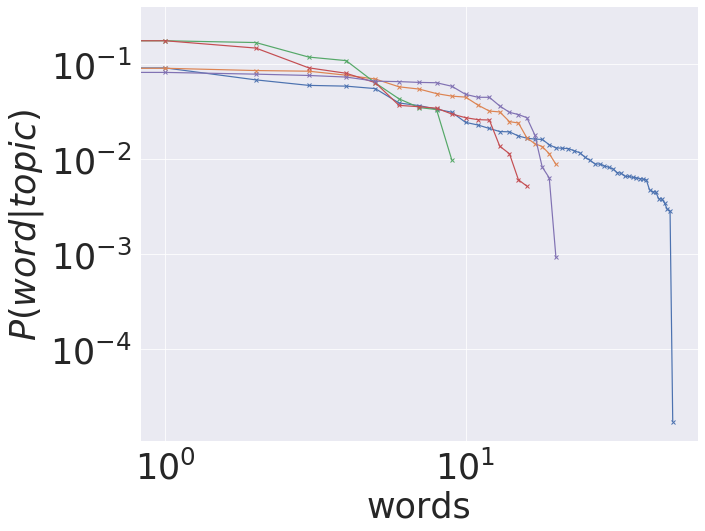

In [4]:
fig=plt.figure(figsize=(10,8))
plt.title("")
for topic in df_Pwt.columns[:5]:
    dist = df_Pwt.sort_values(by=[topic], ascending=False)[topic].astype(float)
    dist = dist[dist>1e-50].values
    if len(dist)<2:
        pass
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic)$", fontsize=35)
plt.xlabel("words", fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(which="both",labelsize=35)
#plt.legend()
plt.show()
fig.savefig("p_w_tw_%s.pdf"%algorithm)

In [5]:
df_Ptd = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L), index_col=1).drop('i_doc',1)

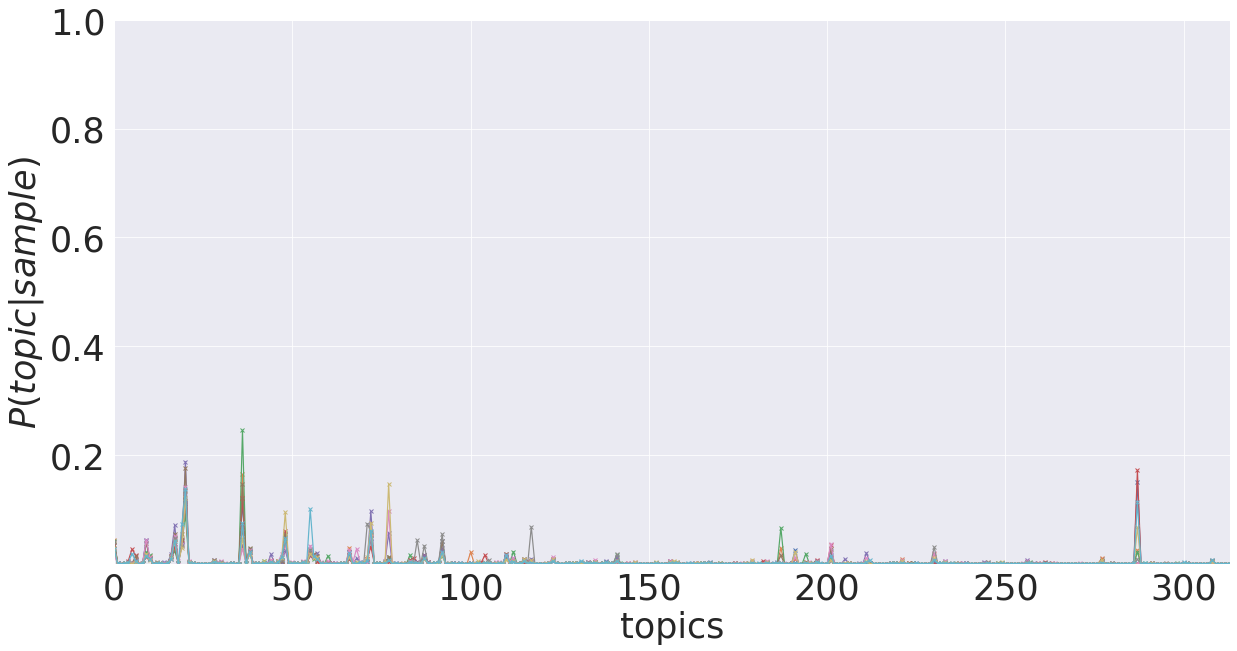

In [6]:
fig=plt.figure(figsize=(20,10))
plt.ylabel("$P(topic | sample$)", fontsize=35)
plt.xlabel("topics", fontsize=35)
for sample in df_Ptd.index.values[:10]:
    plt.plot(df_Ptd.loc[sample,:].astype(float).values, marker='x')
    #plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
#plt.plot(np.logspace(0,2),1/np.logspace(0,2))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlim(0,len(df_Ptd.columns)-2)
plt.tick_params(labelsize=35)
plt.show()
fig.savefig("p_t_s_%s.pdf"%algorithm)

In [56]:
df_mt = pd.read_csv("mainTable.csv",sep=",",index_col=0)
df_mt.index = [g[:15] for g in df_mt.index]
df_files=pd.read_csv("files.dat", index_col=0)
df_mt=df_mt.reindex(index=df_Pwt.index.values.ravel(),
                    columns=[get_file(sample, df_files).name for sample in df_Ptd.index.values.ravel()])
df_mt.dropna(how="all", axis=0, inplace=True)
#df_mt=df_mt.applymap(lambda tpm: np.log2(tpm+1))
#df_mt=df_mt.where(df_mt<1e6,1e6)
df_mt.head()

,TCGA-B6-A0RV-01A-11R-A084-07,TCGA-BH-A1EU-01A-11R-A137-07,TCGA-E9-A1RB-11A-33R-A157-07,TCGA-B6-A0RS-01A-11R-A084-07,TCGA-A8-A06N-01A-11R-A00Z-07,TCGA-AR-A2LL-01A-11R-A180-07,TCGA-BH-A0HL-01A-11R-A10U-07,TCGA-A8-A09Q-01A-11R-A00Z-07,TCGA-BH-A1FR-01A-11R-A13Q-07,TCGA-A8-A07B-01A-11R-A00Z-07,...,GTEX-12WSG-2126-SM-5EGJ7,GTEX-1117F-2426-SM-5EGGH,GTEX-12ZZX-2126-SM-5LZVL,GTEX-POMQ-1226-SM-3P61F,GTEX-11EM3-1926-SM-5987U,GTEX-ZLWG-1026-SM-4WWC4,GTEX-UPIC-1526-SM-4IHLU,GTEX-145ME-1326-SM-5O98Q,GTEX-T2IS-2226-SM-4DM65,GTEX-1399S-2226-SM-5IFEW
A2ML1,1.71,4.66,6.52,0.00,0.65,1.95,0.36,1.17,3.59,37.59,...,0.26,0.52,1.95,NaN,NaN,3.76,NaN,0.27,1.66,NaN
A4GNT,0.34,0.74,2.10,0.00,0.00,0.65,1.23,0.77,0.33,0.00,...,1.20,1.48,0.53,NaN,NaN,0.39,NaN,0.91,0.58,NaN
AADAC,0.30,59.97,223.41,17.38,0.00,2.16,0.00,0.71,0.00,0.00,...,0.00,10.96,0.00,NaN,NaN,0.00,NaN,0.00,27.25,NaN
AARD,140.04,961.07,167.90,1001.93,138.10,69.52,198.47,229.72,67.59,1498.22,...,3.82,1183.45,0.19,NaN,NaN,21.32,NaN,166.73,147.06,NaN
ABAT,723.08,753.83,214.27,23.08,301.33,579.04,444.72,84.04,144.01,136.19,...,60.39,109.66,57.08,NaN,NaN,85.22,NaN,17.77,16.15,NaN


In [47]:
Pgt = tf.convert_to_tensor(df_Pwt.values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.values))
Pgs = tf.matmul(Pgt,Pts)
Ps = tf.convert_to_tensor(df_mt.sum(0).values)
Ps = tf.divide(Ps, tf.reduce_sum(Ps))#normalize
Pg = tf.squeeze(tf.matmul(Pgs, tf.reshape(Ps,[Ps.shape[0],1])))

In [48]:
print(Pgt.shape,Pts.shape,Pgs.shape,Pg.shape, Ps.shape)

(3000, 315) (315, 800) (3000, 800) (3000,) (800,)


In [49]:
Pgs_data = Pgs.numpy()
Pg_data = Pg.numpy()
Pgs_data.shape

(3000, 800)

In [50]:
df_Pgs = pd.DataFrame(data=Pgs_data, index=df_Pwt.values.T[0], columns=df_Ptd.index.values.ravel())

In [51]:
A=df_mt.fillna(0).astype(int).sum(1).values

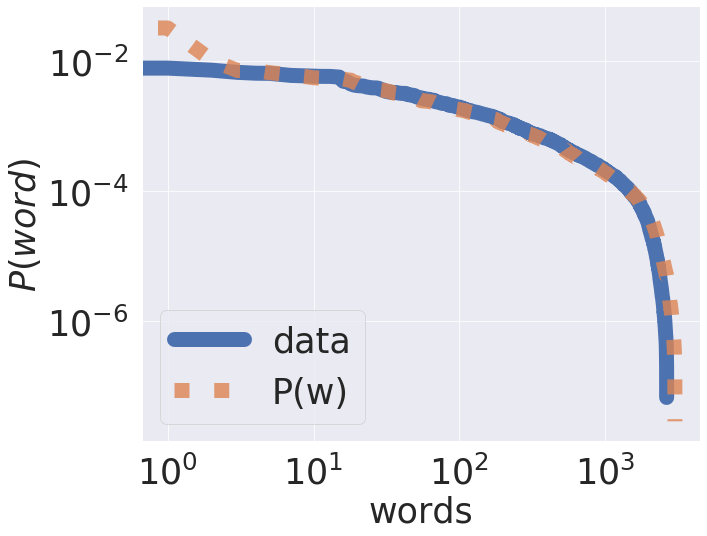

In [52]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=15, ls='-', label='data')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), alpha=0.8, lw=15, ls=':', label='P(w)')
plt.ylabel("$P(word$)", fontsize=35)
plt.xlabel("words", fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=35)
plt.tick_params(which="both", width=25, length=10, labelsize=35)
plt.legend(fontsize=35)
plt.show()
fig.savefig("p_w_%s.pdf"%algorithm)